In [4]:
%load_ext autoreload
%autoreload 2

import sys    
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import pickle
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
from IPython.display import clear_output
from sklearn.utils import shuffle
from torch import Tensor, LongTensor
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

warnings.filterwarnings("ignore", category=DeprecationWarning) 
    
from constants import ARTIFACTS_DIR, PROJECT_DIR, CHECKPOINTS_DIR

from ibmd.core import IBMD
from ibmd.training.callbacks import ImageDataCallback
from pfgmpp.core import PFGMPP
from pfgmpp.training.losses import EDMLoss
from pfgmpp.utils.data import InfiniteDataLoader


# ckpt path
ckpt_name = "cifar10_ncsnpp_D_2048_conditional.pkl"
EDM_CHEKPOINT_PATH = os.path.join(ARTIFACTS_DIR, "checkpoints", "pfgmpp_orig", ckpt_name)

# paths to utils for edm-like models loading
EDM_UTILS_DIR = os.path.join(PROJECT_DIR, "src", "edm_utils")
TORCH_UTILS_DIR = os.path.join(EDM_UTILS_DIR, "torch_utils")
DNNLIB_DIR = os.path.join(EDM_UTILS_DIR, "dnnlib")
sys.path.extend([EDM_UTILS_DIR, TORCH_UTILS_DIR, DNNLIB_DIR])

# run dir
DS_NAME = "cifar10"
RUN_DIR = os.path.join(ARTIFACTS_DIR, "notebooks_outputs", "ibmd", DS_NAME)
IBMD_DIR = os.path.join(RUN_DIR, ckpt_name.split(".")[0])

os.makedirs(IBMD_DIR, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Utils

In [5]:
# Poblem Params (CIFAR-10)
IMG_CHANNELS =  3
IMG_RESOLUTION = 32
DATA_DIM = IMG_CHANNELS * IMG_RESOLUTION**2
N_CLASSES = 10

SIGMA_MIN = 0.002
SIGMA_MAX = 80.0
POWER = 11

# Loss Params
SIGMA_PRIOR_MODE = "log_normal"
SIGMA_DATA = 0.5 

# Sampling params
N_GENS = 4
LABELS = torch.tensor([0] * N_GENS).long()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
def generate(
    *,
    pfgmpp: PFGMPP,
    net: nn.Module,
    sample_size: int,
    num_steps: int=32,
    label: LongTensor=None,
    seed: int=0,
):
    def drift(*, x, t, label):
        return (x - net(x=x, t=t, label=label)) / t
    return pfgmpp.sample(
        drift=drift,
        sample_size=sample_size,
        num_steps=num_steps,
        label=label,
        device=DEVICE,
        seed=seed,
    ).cpu().numpy().reshape(sample_size, IMG_CHANNELS, IMG_RESOLUTION, IMG_RESOLUTION)

def visualize_ibmd(
    *,
    ibmd: IBMD,
    sample_size: int,
    label: LongTensor=None,
    seed: int=0,
):
    gens = ibmd.sample(
        sample_size=sample_size,
        label=label,
        seed=seed,
    ).reshape(-1, IMG_CHANNELS, IMG_RESOLUTION, IMG_RESOLUTION).cpu().numpy()

    ncols = 4
    nrows = (sample_size + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False)
    fig.set_figheight(nrows * 2)
    fig.set_figwidth(ncols * 2)
    
    for ax_idx in range(nrows * ncols):
        i, j = ax_idx // ncols, ax_idx % ncols
        ax = axes[i, j]
        if ax_idx < len(gens):
            ax.axis("off")
            ax.imshow(gens[ax_idx].transpose(1, 2, 0));
        else:
            fig.delaxes(ax)
    plt.show()

In [7]:
class EDMNetWrapper(nn.Module):
    def __init__(
        self,
        *,
        edm_net: nn.Module,
        img_channels: int,
        img_resolution: int,
        n_classes: int=None
    ):
        super().__init__()
        self.edm_net = edm_net

        self.img_channels = img_channels
        self.img_resolution = img_resolution
        self.n_classes = n_classes

        self.data_dim = self.img_channels * self.img_resolution**2

    def forward(self, x: Tensor, t: Tensor, label: LongTensor=None):
        # modify input
        x = x.reshape(-1, self.img_channels, self.img_resolution, self.img_resolution)
        if label is None:
            class_labels = None
        else:
            class_labels = F.one_hot(label, num_classes=self.n_classes)

        # apply edm net
        out = self.edm_net(x=x, sigma=t, class_labels=class_labels)

        # modify output
        return out.reshape(-1, self.data_dim)


# PFGM teacher init

In [8]:
pfgmpp = PFGMPP(
    data_dim=DATA_DIM,
    sigma_min=SIGMA_MIN,
    sigma_max=SIGMA_MAX,
    D=2**POWER,
)


with open(EDM_CHEKPOINT_PATH, "rb") as f:
    net = pickle.load(f)['ema'].to(DEVICE);

pfgmpp_cond = EDMNetWrapper(
    edm_net=net,
    img_channels=IMG_CHANNELS,
    img_resolution=IMG_RESOLUTION,
    n_classes=N_CLASSES,
)
for param in pfgmpp_cond.parameters():
    param.requires_grad = True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85422957..1.0782671].


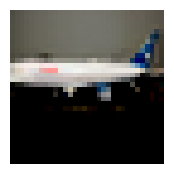

In [40]:
gens = generate(pfgmpp=pfgmpp, net=pfgmpp_cond, sample_size=N_GENS, label=LABELS.to(DEVICE), seed=0)
plt.figure(figsize=(2, 2))
plt.axis("off")
plt.imshow(gens[0].transpose(1, 2, 0));

In [41]:
# IBMD init

In [42]:
BATCH_SIZE = 64
INNER_PROBLEM_ITERS = 5

callback = ImageDataCallback(
    n_classes=N_CLASSES,
    sample_size_per_class=2,
    img_channels=IMG_CHANNELS,
    img_resolution=IMG_RESOLUTION,
)

In [43]:
ibmd = IBMD(
    teacher_dynamics=pfgmpp,
    teacher_net=pfgmpp_cond,
    teacher_loss_fn=EDMLoss(pfgmpp=pfgmpp),
    student_net_optimizer_config={"lr": 3e-4},
    student_data_estimator_net_config={"lr": 3e-4},
    n_classes=N_CLASSES,
    ema_decay=0.99,
)

In [44]:
callback(ibmd, it=0, eval_dir=IBMD_DIR)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.29301047..0.27435303].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.37139603..0.051713377].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16204363..0.25842252].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.34018606..0.14802878].


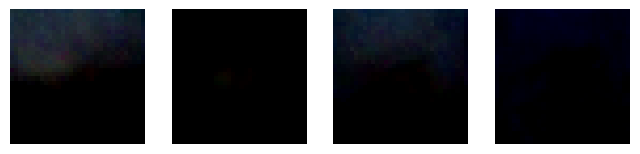

In [45]:
visualize_ibmd(ibmd=ibmd, sample_size=N_GENS, label=LABELS.to(DEVICE), seed=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.56273085..0.5844502].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7650822..0.45523536].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38006666..0.41487876].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4614577..0.43148628].


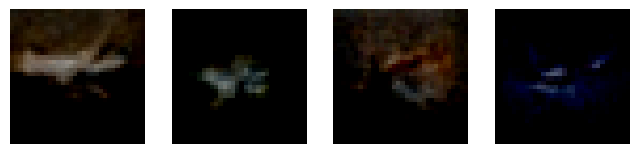

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                   | 27/50 [01:24<01:12,  3.13s/it]


KeyboardInterrupt: 

In [46]:
n_epochs = 500
sample_every = 50

it = 0
for _ in range(n_epochs):
    clear_output()
    visualize_ibmd(ibmd=ibmd, sample_size=N_GENS, label=LABELS.to(DEVICE), seed=0)
    callback(ibmd, it=it, eval_dir=IBMD_DIR, seed=0)

    for _ in tqdm(range(sample_every)):
        ibmd.train_step(
            batch_size=BATCH_SIZE,
            inner_problem_iters=INNER_PROBLEM_ITERS,
        )
        it += 1

In [ ]:
N_GENS = 12
LABELS = torch.tensor([2] * N_GENS).long()
visualize_ibmd(ibmd=ibmd, sample_size=N_GENS, label=LABELS.to(DEVICE), seed=0)